In [19]:
import pandas as pd
import numpy as np

import os
import time
import sys
import platform

import matplotlib.pyplot as plt

In [2]:
INPUT_DATA='./input_data'
classical_life_stage_csv = f"{INPUT_DATA}/classical_life_stage.csv"

if os.path.isfile(classical_life_stage_csv):
    classical_life_stage_df = pd.read_csv(classical_life_stage_csv)
    print(f"File exists. Loaded DataFrame: {classical_life_stage_csv}")
    print(f"You may skip 'Get Raw Life Stages data from Wormbase' section")
else:
    print("File does not exist.")

File exists. Loaded DataFrame: ./input_data/classical_life_stage.csv
You may skip 'Get Raw Life Stages data from Wormbase' section


## Get Raw Life Stages data from Wormbase

__Note:__ Change `WORMBASE_VERSION="WS288"` as appropriate.

In [3]:
%%bash
# Select Version from https://wormbase.org/ 
WORMBASE_VERSION="WS288"

base_dir="./input_data"


base_url="ftp://ftp.wormbase.org/pub/wormbase/releases/${WORMBASE_VERSION}/species/c_elegans/PRJNA13758/annotation"
expr_graph="c_elegans.PRJNA13758.${WORMBASE_VERSION}.expr_graph.csv.gz"

mkdir -p ${base_dir}
cd ${base_dir}

wget -nv ${base_url}/${expr_graph}
gunzip -f ${expr_graph}


2023-09-13 14:33:40 URL: ftp://ftp.wormbase.org/pub/wormbase/releases/WS288/species/c_elegans/PRJNA13758/annotation/c_elegans.PRJNA13758.WS288.expr_graph.csv.gz [39983990] -> "c_elegans.PRJNA13758.WS288.expr_graph.csv.gz" [1]


## Read Life Stages into a Data frame

* Remove Quotes surounding Strings
* Convert FPMK Data to float
* Select ONLY Where Library=='Median'
* Select ONLY Classical Life Stages ['EE','LE','L1','L2','L3','L4','YA', 'Dauer']

__Note:__ Change `WORMBASE_VERSION="WS288"` as appropriate.

In [4]:
# Import the Graph data from Wormbase

WORMBASE_VERSION="WS288"
INPUT_DATA='./input_data'
expr_graph=f'{INPUT_DATA}/c_elegans.PRJNA13758.{WORMBASE_VERSION}.expr_graph.csv'
clean_str = lambda x: x.replace('"','').strip()
clean_float = lambda x: float(x.replace('"','').strip())

columns = ["Gene", "Gene_name", "Life_stage", "Library", "Protocol", "FPKM_value"]
expr_graph_df = pd.read_csv(expr_graph,low_memory=False, header=None, names=columns,
                            skiprows=1,
                            converters={'Gene_name':clean_str, 'Life_stage':clean_str, 
                                        'Library':clean_str, 'Protocol':clean_str,
                                        'FPKM_value':clean_float})
print(f"{len(expr_graph_df):,} rows of data")

6,648,629 rows of data


In [5]:
expr_graph_median_protocol_df = expr_graph_df[expr_graph_df['Library']=='Median']
print(f"{len(expr_graph_median_protocol_df):,} rows of data")

1,791,944 rows of data


In [6]:
expr_graph_median_protocol_w_stages_df = expr_graph_median_protocol_df.query("Life_stage in ['EE','LE','L1','L2','L3','L4','YA', 'Dauer']")
print(f"{len(expr_graph_median_protocol_w_stages_df):,} rows of data")

377,246 rows of data


In [7]:
# Create a Dataframe with approriate dimensions for ML

classical_life_stage_dict = {}
empty_entry = {'EE':None,'LE':None,'L1':None,'L2':None,'L3':None,'L4':None,'YA':None, 'Dauer':None}

for index, row in expr_graph_median_protocol_w_stages_df.iterrows():
    if row['Gene'] not in classical_life_stage_dict:
        classical_life_stage_dict[row['Gene']] = empty_entry.copy()
        
    classical_life_stage_dict[row['Gene']][row['Life_stage']]=row['FPKM_value']
                                           
classical_life_stage_df = pd.DataFrame.from_dict(classical_life_stage_dict, orient='index')
classical_life_stage_df = classical_life_stage_df.reset_index()
classical_life_stage_df = classical_life_stage_df.rename(columns={'index':'wormbase_id'})
classical_life_stage_df

,wormbase_id,EE,LE,L1,L2,L3,L4,YA,Dauer
0,WBGene00000001,33.898200,26.932200,21.436350,1.658970e+01,11.968985,12.447850,3.186940e+01,28.753700
1,WBGene00000002,23.441200,33.813650,9.265820,1.482530e+01,14.730250,9.160820,3.548910e+00,4.495965
2,WBGene00000003,21.021800,27.326450,19.264155,2.194982e+01,18.471600,8.581130,4.936450e+00,2.958700
3,WBGene00000004,93.562800,169.513550,58.897750,1.694610e+01,12.458700,5.370920,3.732810e+00,17.807400
4,WBGene00000005,1.605870,1.984195,1.484667,4.866360e+00,9.004410,10.464590,8.643980e+00,0.222242
...,...,...,...,...,...,...,...,...,...
47152,WBGene00306126,14.227600,13.483950,8.306865,1.385340e+01,18.601700,13.256385,1.571320e+01,14.587240
47153,WBGene00306131,0.475715,2.266691,12.987540,1.522980e+01,18.196750,17.269800,9.699470e+00,2.714450
47154,WBGene00306132,25.407000,22.456700,0.766550,1.000000e-10,0.060663,2.709325,4.643130e+00,0.726155
47155,WBGene00306133,21.872000,62.513380,23.747425,3.888440e+01,27.498500,33.294600,8.646710e+00,23.439850


In [8]:
classical_life_stage_df.to_csv(INPUT_DATA + '/classical_life_stage.csv', index=None, header=True)

In [1]:
%whos

Interactive namespace is empty.


In [10]:
# Clean up a few temp objects temp objects
for object_name in ['expr_graph_df', 'expr_graph_median_protocol_df', 'expr_graph_median_protocol_w_stages_df','classical_life_stage_dict']:
    if object_name in locals():
        print(f"Clean up object: {object_name}")
        del globals()[object_name]

Clean up object: expr_graph_df
Clean up object: expr_graph_median_protocol_df
Clean up object: expr_graph_median_protocol_w_stages_df
Clean up object: classical_life_stage_dict


29.62%
13,966


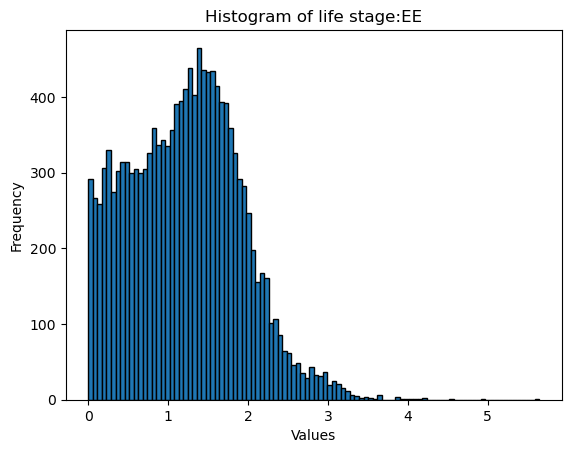

34.04%
16,051


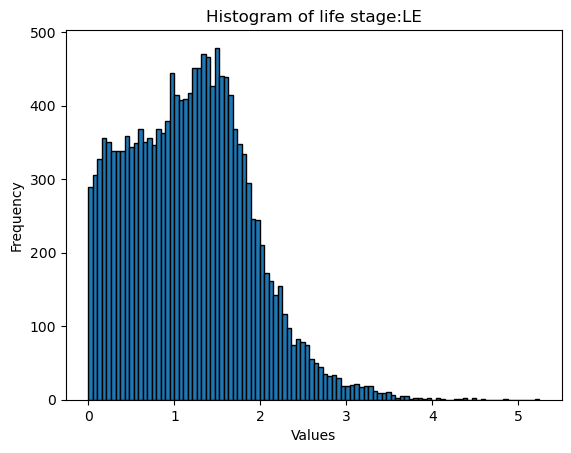

30.1%
14,193


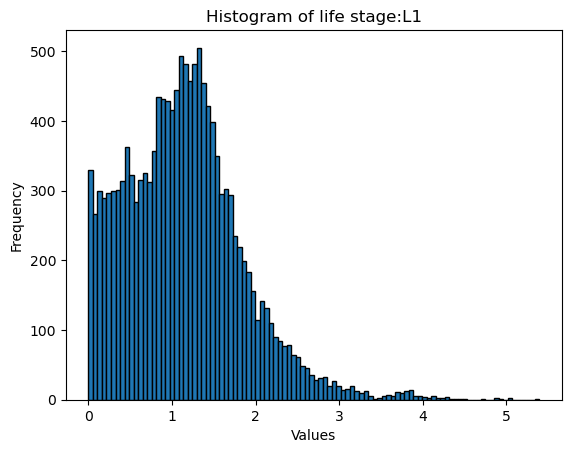

28.77%
13,565


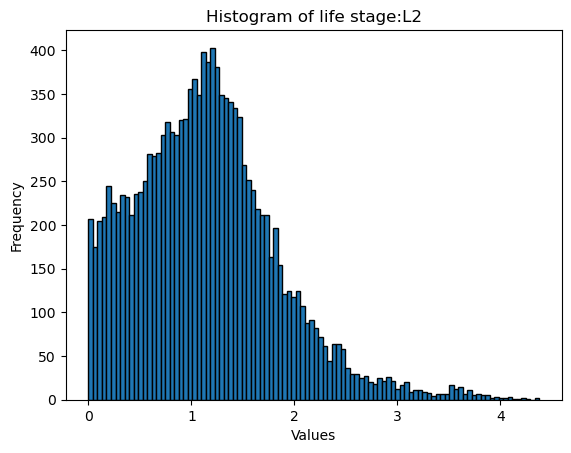

34.08%
16,073


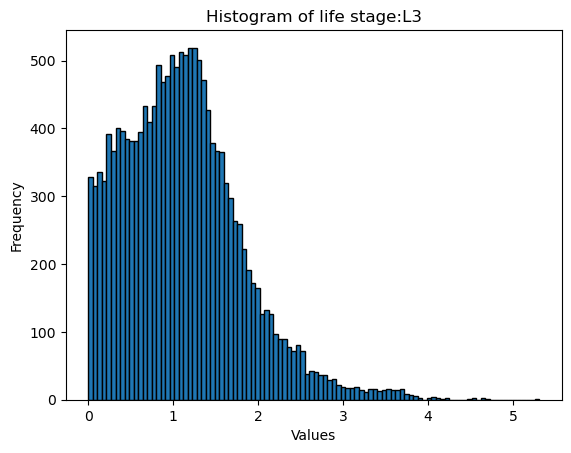

35.26%
16,626


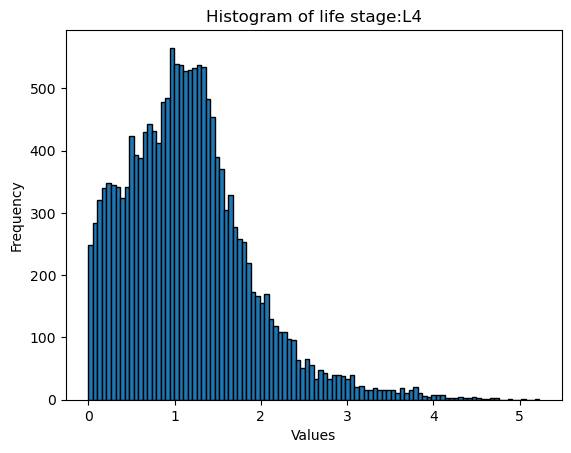

29.26%
13,796


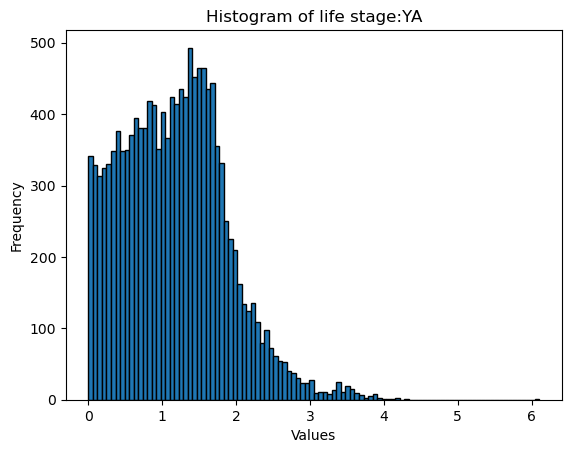

30.08%
14,185


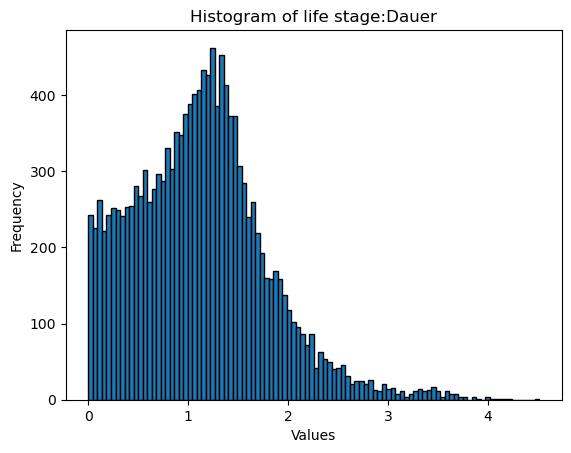

In [43]:
def plot_life_stage(stage):
    #filtered_series = np.log10(classical_life_stage_df['EE'] + 0.0001)
    filtered_series = classical_life_stage_df[classical_life_stage_df[stage] > 1][stage]
    filtered_series = np.log10(filtered_series)
    print(f"{round(len(filtered_series)/len(classical_life_stage_df)*100,2)}%")
    print(f"{len(filtered_series):,}")                        
    plt.hist(filtered_series, bins=100, edgecolor='k')  # Adjust the number of bins as needed
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of life stage:{stage}')
    plt.show()
    
for life_stage in ['EE','LE','L1','L2','L3','L4','YA', 'Dauer']:
    plot_life_stage(life_stage)
 

In [17]:
max_values = classical_life_stage_df.max()
min_values = classical_life_stage_df.min()

# Print or use the max and min values as needed
print("Maximum Values:")
print(max_values)

print("\nMinimum Values:")
print(min_values)

Maximum Values:
wormbase_id    WBGene00306134
EE                   446421.0
LE                  176123.47
L1                   249615.0
L2                    23893.5
L3                 204815.364
L4                 169825.976
YA                  1277560.0
Dauer                32801.45
dtype: object

Minimum Values:
wormbase_id    WBGene00000001
EE                        0.0
LE                        0.0
L1                        0.0
L2                        0.0
L3                        0.0
L4                        0.0
YA                        0.0
Dauer                     0.0
dtype: object
